## Handwritten Digit Recognition using a Convolutional Neural Network

This tutorial shows you how to design a deep convolutional neural network for a classic computer vision application: identify hand-written digits.

We are going to use MNIST dataset for training, validation and our convolutional neural network model.


In [10]:
import numpy as np
import timeit
import aurora as au # import Aurora 
import aurora.autodiff as ad # importing Aurora's automatic differentiation framework 
import matplotlib.pyplot as plt
import seaborn as sbn
sbn.set()

BATCH_SIZE = 64
LR = 1e-4
USE_GPU = False
NUM_ITERS = 20

# utility functions
def display_images(image_dataset, n_rows, n_cols, graph_title='Sample Training Images'):
    '''
    Simple utility function for displaying images.
    '''
    plt.figure(figsize=(7, 5))
    image_number = 1
    for row in range(n_rows):
        for col in range(n_cols):
            plt.subplot(n_rows, n_cols, image_number)
            plt.imshow(image_dataset[image_number-1, :], cmap='Greys_r') 
            plt.axis('off')
            image_number += 1
    plt.suptitle(graph_title)
    plt.show()
    
def measure_accuracy(activation, X_val, y_val, batch_size=32, use_gpu=USE_GPU):
    executor = ad.Executor([activation], use_gpu=use_gpu)

    max_val = len(X_val) - len(X_val) % batch_size
    y_val = y_val[0:max_val]

    prediction = np.zeros(max_val)
    for i in range(0, max_val, batch_size):
        start = i
        end = i + batch_size

        X_batch, y_batch = X_val[start:end], y_val[start:end]
        prob_val, = executor.run(feed_shapes={images: X_batch})

        if use_gpu:
            prob_val = prob_val.asnumpy()
        prediction[start:end] = np.argmax(prob_val, axis=1)

    correct = np.sum(np.equal(y_val, prediction))
    percentage = (correct / len(prediction)) * 100.00
    return percentage

### Let's Explore the Dataset

The original MNIST dataset consists of 60000 training and 10000 validation images. In our implementation, we use 10000 out of 60000 images as our validation set.

So let's plot some sample images.

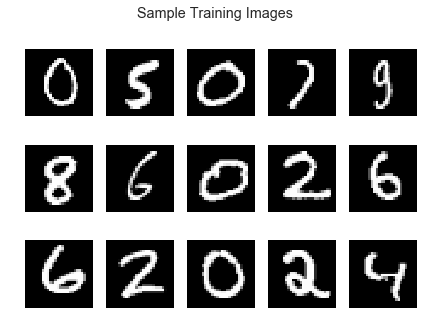

In [9]:
data = au.datasets.MNIST(batch_size=BATCH_SIZE)
batch_generator = data.train_batch_generator()
batch = next(batch_generator)

sample = batch[0][0:15, :]
display_images(sample.reshape(-1, 28, 28), 3, 5)

### Building the Computational Graph

**Aurora** uses dataflow graph approach to define neural networks. So following cell defines our simple convolutional neural network which we going to train in the next cell. 

In [4]:
def build_network(image, y, batch_size=32):
    rand = np.random.RandomState(seed=1024)

    reshaped_images = ad.reshape(image, newshape=(batch_size, 1, 28, 28))

    # weight in (number_kernels, color_depth, kernel_height, kernel_width)
    W1 = ad.Parameter(name='W1', init=rand.normal(scale=0.1, size=(10, 1, 5, 5)))
    b1 = ad.Parameter(name='b1', init=rand.normal(scale=0.1, size=10))
    conv1 = au.nn.conv2d(input=reshaped_images, filter=W1, bias=b1)
    activation1 = au.nn.relu(conv1)
    # size of activation1: batch_size x 10 x 24 x 24

    # weight in (number_kernels, number_kernels of previous layer, kernel_height, kernel_width)
    W2 = ad.Parameter(name='W2', init=rand.normal(scale=0.1, size=(5, 10, 5, 5)))
    b2 = ad.Parameter(name='b2', init=rand.normal(scale=0.1, size=5))
    conv2 = au.nn.conv2d(input=activation1, filter=W2, bias=b2)
    activation2 = au.nn.relu(conv2)
    # size of activation2: batch_size x 5 x 20 x 20 = batch_size x 2000

    flatten = ad.reshape(activation2, newshape=(batch_size, 2000))

    W3 = ad.Parameter(name='W3', init=rand.normal(scale=0.1, size=(2000, 500)))
    b3 = ad.Parameter(name='b3', init=rand.normal(scale=0.1, size=500))
    Z3 = ad.matmul(flatten, W3)
    Z3 = Z3 + ad.broadcast_to(b3, Z3)
    activation3 = au.nn.relu(Z3)

    W4 = ad.Parameter(name='W4', init=rand.normal(scale=0.1, size=(500, 10)))
    b4 = ad.Parameter(name='b4', init=rand.normal(scale=0.1, size=10))
    logits = ad.matmul(activation3, W4)
    logits = logits + ad.broadcast_to(b4, logits)
    loss = au.nn.cross_entropy_with_logits(logits, y)

    return loss, W1, b1, W2, b2, W3, b3, W4, b4, logits

### Training Our Model


OK, now we defined our model using Aurora. Now its time to train our model. For training, we use Adam optimizer. 

In [ ]:
n_iter = NUM_ITERS
start = timeit.default_timer()

data = au.datasets.MNIST(batch_size=BATCH_SIZE)
batch_generator = data.train_batch_generator()

# images in (batch_size, color_depth, height, width)
images = ad.Variable(name='images')
labels = ad.Variable(name='y')

loss, W1, b1, W2, b2, W3, b3, W4, b4, logits = build_network(images, labels, batch_size=64)
opt_params = [W1, b1, W2, b2, W3, b3, W4, b4]
optimizer = au.optim.Adam(loss, params=opt_params, lr=1e-4, use_gpu=USE_GPU)

training_errors = []
validation_erros = []

for i in range(n_iter):
    X_batch, y_batch = next(batch_generator)
    loss_now = optimizer.step(feed_dict={images: X_batch, labels: y_batch})
    if i <= 10 or (i <= 100 and i % 10 == 0) or (i <= 1000 and i % 100 == 0) or (i <= 10000 and i % 500 == 0):
        fmt_str = 'iter: {0:>5d} cost: {1:>8.5f}'
        print(fmt_str.format(i, loss_now[0]))
        
    if i % 10 == 0:
        train_acc = measure_accuracy(logits, X_batch, np.argmax(y_batch, axis=1), 
                                     batch_size=BATCH_SIZE, use_gpu=USE_GPU)
        training_errors.append((100.0 - train_acc))
        
        X_valid, y_valid = data.validation()
        valid_acc = measure_accuracy(logits, X_valid[0:BATCH_SIZE], y_valid[0:BATCH_SIZE],  
                                     batch_size=BATCH_SIZE, use_gpu=USE_GPU)
        validation_erros.append((100.0 - valid_acc))

### Reporting Testing Accuracy and Plotting Training/Validation Errors

In [5]:
X_valid, y_valid = data.validation()
val_acc = measure_accuracy(logits, X_valid, y_valid, batch_size=BATCH_SIZE, use_gpu=USE_GPU)
print('Validation accuracy: {:>.2f}'.format(val_acc))

Validation accuracy: 97.23


In [6]:
X_test, y_test = data.testing()
test_acc = measure_accuracy(logits, X_test, y_test, batch_size=BATCH_SIZE, use_gpu=USE_GPU)
print('Testing accuracy: {:>.2f}'.format(test_acc))

Testing accuracy: 97.11


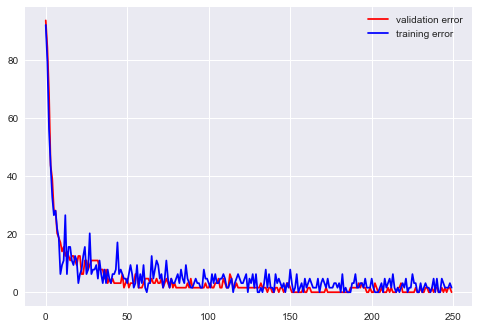

In [7]:
plt.plot(validation_erros, color='r', label='validation error')
plt.plot(training_errors, color='b', label='training error')
plt.legend()
plt.show()